# 概要

機械学習において重要トピックの一つであるハイパーパラメータのチューニング方法を実装してみる。

今回california_housingをつかって、ランダムサーチによる探索を試す。

# ランダムサーチ：sklearn.datasets.fetch_california_housing

## パッケージインポート

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense  # layerクラスを直接インポートして使用出来る

##### これうまくいくはずなんだけど学習できてない #####
from tensorflow.keras.losses import MeanSquaredError  # 損失関数クラスを直接インポートして使用出来る
from tensorflow.keras.optimizers import SGD  # オプティマイザクラスを直接インポートして使用出来る
##################################################

import numpy as np
import pandas as pd

print(f'tensorflow ver.{tf.__version__}')
print(f'keras ver.{keras.__version__}')

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tensorflow ver.2.5.0
keras ver.2.5.0


##  データロードと前処理

### データロード

In [2]:
housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target)


### validation分割

In [3]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full)

# データサイズを確認
print(f'x_train.shape : {x_train.shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'x_valid.shape : {x_valid.shape}')
print(f'y_valid.shape : {y_valid.shape}')

x_train.shape : (11610, 8)
y_train.shape : (11610,)
x_valid.shape : (3870, 8)
y_valid.shape : (3870,)


trainデータを確認

In [4]:
pd_x_train = pd.DataFrame(x_train, columns=housing.feature_names)
display(pd_x_train)
pd_x_train.info()
pd_x_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.3241,43.0,3.556962,0.940928,1590.0,3.354430,33.96,-118.21
1,3.4338,34.0,4.719064,0.976589,1040.0,3.478261,33.87,-117.90
2,3.9688,17.0,5.163934,0.963934,1857.0,3.044262,38.41,-122.75
3,3.8703,23.0,3.765926,1.143704,1720.0,2.548148,33.73,-117.82
4,4.8266,13.0,6.746647,1.062593,2170.0,3.233979,35.37,-119.12
...,...,...,...,...,...,...,...,...
11605,2.5444,35.0,3.374622,1.040785,1334.0,2.015106,34.09,-118.35
11606,2.8542,52.0,5.457831,0.993976,257.0,1.548193,38.56,-121.44
11607,1.8958,39.0,5.014409,1.011527,1098.0,3.164265,36.74,-119.75
11608,5.0947,14.0,5.076923,1.038462,943.0,3.626923,32.68,-117.04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11610 entries, 0 to 11609
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      11610 non-null  float64
 1   HouseAge    11610 non-null  float64
 2   AveRooms    11610 non-null  float64
 3   AveBedrms   11610 non-null  float64
 4   Population  11610 non-null  float64
 5   AveOccup    11610 non-null  float64
 6   Latitude    11610 non-null  float64
 7   Longitude   11610 non-null  float64
dtypes: float64(8)
memory usage: 725.8 KB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000
mean,3.867776,28.548407,5.414145,1.094958,1434.260121,3.095149,35.635297,-119.570068
std,1.914944,12.577928,2.150883,0.391669,1164.028593,12.818691,2.141518,2.006623
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000
25%,2.560075,18.000000,4.442996,1.006508,783.000000,2.428093,33.940000,-121.790000
50%,3.531300,29.000000,5.223172,1.049645,1166.000000,2.816695,34.250000,-118.490000
75%,4.724300,37.000000,6.057367,1.100295,1733.000000,3.279891,37.720000,-118.010000
max,15.000100,52.000000,62.422222,15.312500,35682.000000,1243.333333,41.950000,-114.470000


### 前処理

#### スケーリング

### [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
データの標準化を行う。

代表的なメソッドは以下：

|メソッド|説明|
|---|---|
|fit()|標準化するための平均と分散を計算する。|
|trasform()|（事前に計算した平均と分散を使用して）標準化を行う。|
|fit_transform()|平均と分散を計算し、標準化を行う。|

In [5]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)  # x_trainの平均・分散を使用する（のはなぜ？）
x_test = scaler.transform(x_test)  # x_trainの平均・分散を使用する（のはなぜ？）

## モデル作成

複数のモデルを比較しやすくするようにモデルを作成する関数を定義しておく。

この関数では引数で渡した層の数、各層のニューロン数、学習率でSequentialモデル作成→SGDオプティマイザでコンパイルまで行い、モデルを返す。

In [6]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[x_train.shape[1]]):
    # Sequentialモデル生成
    model = keras.models.Sequential()
    # InputLayer追加
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    # hiddenLayer追加
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    # OutputLayer追加
    model.add(keras.layers.Dense(1))

    # optimizer生成
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    # compile
    model.compile(loss='mse', optimizer=optimizer)

    return model

# build_modelを使ってKerasRegressorを作る
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

KerasRegressorオブジェクトはbuild_modelを使って構築されるモデルに薄いラップをかぶせたものである。<br>
（このラップによって？）scikit-learnの回帰モデルを同じようなユーザインタフェースを使用することが出来る。

## 学習と評価

### コールバックによる学習中のチェックポイント保存

今回早期打ち切り設定を入れるためにEarlyStopping関数を使用する。

また、コールバック関数は自作したものを使うことが出来る。<br>
例として学習中の訓練データのlossとvalidationデータのlossの比率を表示する関数を作成する。（過学習を検知すること想定）

In [7]:
# 早期打ち切りのコールバック関数
# 学習打ち切り時に性能が最高だった時の重みを復元するので最良モデルの保存と復元は不要
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)  # patienceで指定したエポック数学習が進まなかったときに学習を打ち切る

In [8]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

print_valid_train_ration_cb = PrintValTrainRatioCallback()

### TensorBoardを使った可視化

In [9]:
import os

# ログ出力のルートディレクトリ
root_dir = os.path.join(os.curdir, 'my_logs')

# ログディレクトリ名を生成する関数
def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_dir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### 学習

scikit-learnのようにfitメソッドで学習する。<br>
ただし引数はbuild_modelの土台になっているkerasモデルに渡される。<br>
その例として以下ではcallbackを渡している。

In [10]:
# scikit-learnのようにfitメソッドで学習.
keras_reg.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), callbacks=[early_stopping_cb,print_valid_train_ration_cb,tensorboard_cb])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.5222 - val_loss: 0.7017

val/train: 0.46
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6771 - val_loss: 0.6008

val/train: 0.89
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5856 - val_loss: 0.5612

val/train: 0.96
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5494 - val_loss: 0.5393

val/train: 0.98
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5273 - val_loss: 0.5227

val/train: 0.99
Epoch 6/100
363/363 [==============================] - 0s 977us/step - loss: 0.5115 - val_loss: 0.5134

val/train: 1.00
Epoch 7/100
363/363 [==============================] - 0s 987us/step - loss: 0.5006 - val_loss: 0.5005

val/train: 1.00
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4926 - val_loss: 0.4928

val/train: 1.00
Epoch 9/100
363/363 [==============================]

In [11]:
%load_ext tensorboard

%tensorboard --logdir ./my_logs

Reusing TensorBoard on port 6006 (pid 29808), started 4 days, 0:54:06 ago. (Use '!kill 29808' to kill it.)

### 評価

In [12]:
# scikit-learnのようにscoreメソッドで評価(scoreは高いほぼ良い)
mse_test = keras_reg.score(x_test, y_test)
mse_test

162/162 [==============================] - 0s 531us/step - loss: 0.3509


-0.35093608498573303

## 学習済みモデルを使った予測

In [13]:
# サンプル用にデータサイズを限定
x_new = x_test[:3]

# scikit-learnのようにpredictメソッドで予測
y_pred = keras_reg.predict(x_new)
print(f'predict : {y_pred.reshape(-1)}')
print(f'correct : {y_test[:3]}')

predict : [2.5911822 1.6748192 1.6262096]
correct : [2.103 2.259 1.52 ]


## ランダムサーチによるパラメータ探索

ここまででパラメータ探索をするモデル側の準備が出来たので、実際にランダムサーチを使って探索を行う。

## モデルの保存と復元

In [14]:
from scipy.stats import reciprocal  # 逆分布（対数一様分布）
from sklearn.model_selection import RandomizedSearchCV  # ランダムサーチ

param_distribs = {
    'n_hidden' : [0, 1, 2, 3],
    'n_neurons' : np.arange(1, 100),
    'learning_rate' : reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(estimator=keras_reg  # パラメータ探索を行うモデル
                                    , param_distributions=param_distribs  # パラメータ探索を試すパラメータの分布またはリストの辞書
                                    , n_iter=10  # 試行回数
                                    , cv=3  # 交差検証の分割数
                                    )
rnd_search_cv.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), callbacks=[early_stopping_cb,print_valid_train_ration_cb,tensorboard_cb])

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 2.3168 - val_loss: 1.4620

val/train: 0.63
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.1642 - val_loss: 0.9538

val/train: 0.82
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8796 - val_loss: 0.7932

val/train: 0.90
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7779 - val_loss: 0.7243

val/train: 0.93
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7279 - val_loss: 0.6852

val/train: 0.94
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6938 - val_loss: 0.6576

val/train: 0.95
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6677 - val_loss: 0.6342

val/train: 0.95
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6449 - val_loss: 0.6149

val/train: 0.95
Epoch 9/100
242/242 [==============================] - 0

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001F9F7AA3848>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F9FE740B08>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

fitメソッドに渡した引数はその下のkerasモデルにリレーされている。<br>
また、RandomizedSearchCVは交差検証を使用するため学習精度を評価するためにx_valid, y_validは使わない。これらは早期打ち切りのために使用される。

次のように最良のパラメータ、スコア、モデルを取得できる。

In [18]:
# 最良モデルのインデックス
print(rnd_search_cv.best_index_)

# 最良モデルのパラメータ
print(rnd_search_cv.best_params_)

# 最良モデルのスコア
print(rnd_search_cv.best_score_)

# 最良モデル
model = rnd_search_cv.best_estimator_.model
print(model.evaluate(x_test, y_test))

6
{'learning_rate': 0.0036801093876061867, 'n_hidden': 2, 'n_neurons': 92}
-0.3339237868785858
162/162 [==============================] - 0s 1ms/step - loss: 0.2912
0.2911567687988281


# 補足

scipy.statsは確率分布、統計量、仮説検定などの統計に関するモジュールを収録している. <br>
reciprocal は逆分布（対数一様分布）<br>
確率密度関数は
$$ f(x;a,b)={\frac {1}{x[\log _{e}(b)-\log _{e}(a)]}}\quad {\text{ for }}a\leq x\leq b{\text{ and }}a>0. $$
パラメータの説明をすると、$a$は下限, $b$は上限を与える.（←本当かな？）

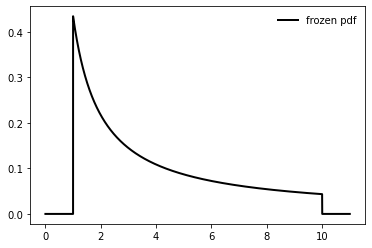

In [16]:
from scipy.stats import reciprocal  # 逆分布（対数一様分布）
from matplotlib import pyplot as plt

x = np.linspace(start=0, stop=11, num=10000) 
dist = reciprocal(1, 10)

fig, ax = plt.subplots(1, 1)
ax.plot(x, dist.pdf(x), 'k-', lw=2, label='frozen pdf')
ax.legend(loc='best', frameon=False)
plt.show()